In [1]:
using Images

In [2]:
struct Node
    id::Int
    label::String
end

struct Edge
    label::String
    source::Node
    target::Node
end

function id_generator(;init=10000)
    id = init
    return ()->(id+=1)
end

struct Graph
    nodes::Vector{Node}
    edges::Vector{Edge}
    gen_id::Function
    function Graph()
        nodes = Node[]
        edges = Edge[]
        gen_id = id_generator()
        new(nodes, edges, gen_id)
    end
end


function add_node!(graph::Graph, label::String)
    node = Node(graph.gen_id(), label)
    push!(graph.nodes, node)
    return node
end

function add_edge!(graph::Graph, label::String, source::Node, target::Node)
    edge = Edge(label, source, target)
    push!(graph.edges, edge)
    return edge
end

add_edge! (generic function with 1 method)

In [3]:
function to_graph(f::Expr)::Graph
    graph = Graph()
    root = add_node!(graph, string(f.args[1]))
    for arg in f.args[2:end]
        dfs!(arg, root, graph)
    end
    return graph
end

function dfs!(f::Expr, parent::Node, graph::Graph)
    @assert f.head == :call
    op = f.args[1]
    node = add_node!(graph, string(op))
    edge = add_edge!(graph, "", parent, node)
    for arg in f.args[2:end]
        dfs!(arg, node, graph)
    end
end

function dfs!(f::Symbol, parent::Node, graph::Graph)
    node = add_node!(graph, string(f))
    edge = add_edge!(graph, "", parent, node)
end

function dfs!(f::Int64, parent::Node, graph::Graph)
    node = add_node!(graph, string(f))
    edge = add_edge!(graph, "", parent, node)
end


dfs! (generic function with 3 methods)

In [4]:
function to_graphviz(g::Graph)::String
    s = """digraph G {
        node [shape=plaintext, fontname=\"Courier New\", fontsize=30, shape=none];
        edge [fontname=\"Courier New\", fontsize=12, penwidth=0.5, arrowsize=0.5];
    """
    for node in g.nodes
        s *= "    $(node.id) [label=\"$(node.label)\"];\n"
    end
    for edge in g.edges
        s *= "    $(edge.source.id) -> $(edge.target.id) [label=\"$(edge.label)\"];\n"
    end
    s *= "}\n"
    return s
end

to_graphviz (generic function with 1 method)

In [5]:
function to_latex(ex::Expr)::String
    @assert ex.head == :call
    op = ex.args[1]
    if op == :+
        return "\\left(" * to_latex(ex.args[2]) * " + " * to_latex(ex.args[3]) * "\\right)"
    elseif op == :-
        return "\\left(" * to_latex(ex.args[2]) * " - " * to_latex(ex.args[3]) * "\\right)"
    elseif op == :*
        return to_latex(ex.args[2]) * " \\cdot " * to_latex(ex.args[3])
    elseif op == :/
        return "\\dfrac{" * to_latex(ex.args[2]) * "}{" * to_latex(ex.args[3]) * "}"
    elseif op == :^
        inner = to_latex(ex.args[2])
        if length(inner) > 1
            inner = "\\left(" * inner * "\\right)"
        end
        return inner * "^{" * to_latex(ex.args[3]) * "}"
    else
        throw("Unknown operator $op")
    end
end


function to_latex(ex::Symbol)::String
    return string(ex)
end

function to_latex(ex::Int64)::String
    return string(ex)
end

to_latex (generic function with 3 methods)

In [6]:
println(to_latex(:((2 * x ^ 2 - (1 + x) * (2 * (2x))) / (2 * x ^ 2) ^ 2)))

\dfrac{\left(2 \cdot x^{2} - \left(1 + x\right) \cdot 2 \cdot 2 \cdot x\right)}{\left(2 \cdot x^{2}\right)^{2}}


In [7]:
function plot_graphviz(src::String)
    f = open("tmp.dot", "w")
    write(f, src)
    close(f)
    run(`dot -Tpng tmp.dot -o tmp.png`)
    run(`rm tmp.dot`)
    img = load("tmp.png")
    run(`rm tmp.png`)
    return img
end

plot_graphviz (generic function with 1 method)

In [8]:
macro plot(ex)
    return ex |> to_graph |> to_graphviz |> plot_graphviz
end

@plot (macro with 1 method)

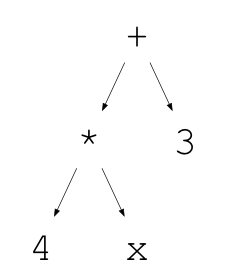

In [9]:
(@plot 4x + 3)

In [10]:
function derivative(ex::Expr)::Expr
    op = ex.args[1]
    if op == :+
        return Expr(:call, :+, derivative(ex.args[2]), derivative(ex.args[3]))
    elseif op == :*
        return Expr(
            :call,
            :+,
            Expr(:call, :*, ex.args[2], derivative(ex.args[3])),
            Expr(:call, :*, derivative(ex.args[2]), ex.args[3])
        )
    else
        error("not implemented")
    end
end

derivative(ex::Symbol) = 1

derivative(ex::Int64) = 0

derivative (generic function with 3 methods)

In [11]:
f = :(x * x + 3)
df = derivative(f)

:((x * 1 + 1x) + 0)

In [12]:
x = 10
eval(df)

20

In [13]:
derivative(:(x * x)) |> println

x * 1 + 1x


In [14]:
f = :(2 * x * x + 3 * x + 1)

:(2 * x * x + 3x + 1)

In [15]:
f |> to_graph |> to_graphviz |> println

digraph G {
    node [shape=plaintext, fontname="Courier New", fontsize=30, shape=none];
    edge [fontname="Courier New", fontsize=12, penwidth=0.5, arrowsize=0.5];
    10001 [label="+"];
    10002 [label="*"];
    10003 [label="2"];
    10004 [label="x"];
    10005 [label="x"];
    10006 [label="*"];
    10007 [label="3"];
    10008 [label="x"];
    10009 [label="1"];
    10001 -> 10002 [label=""];
    10002 -> 10003 [label=""];
    10002 -> 10004 [label=""];
    10002 -> 10005 [label=""];
    10001 -> 10006 [label=""];
    10006 -> 10007 [label=""];
    10006 -> 10008 [label=""];
    10001 -> 10009 [label=""];
}



In [16]:
dump(:(2 * x * x))

Expr
  head: Symbol call
  args: Array{Any}((4,))
    1: Symbol *
    2: Int64 2
    3: Symbol x
    4: Symbol x


In [17]:
function add(args)
    args = filter(x->x != 0, args)
    if length(args) == 0
        return 0
    elseif length(args) == 1
        return args[1]
    else
        return Expr(:call, :+, args...)
    end
end

function sub(args)
    @assert length(args) == 2
    if args[2] == 0
        return args[1]
    else
        return Expr(:call, :-, args...)
    end
end

function mul(args)
    if 0 in args
        return 0
    end

    args = filter(x->x != 1, args)
    # 全部 1 だった場合
    if length(args) == 0
        return 1
    # 一個だけ残った場合
    elseif length(args) == 1
        return args[1]
    else
        return Expr(:call, :*, args...)
    end
end

function div(args)
    @assert length(args) == 2
    if args[2] == 1
        return args[1]
    else
        return Expr(:call, :/, args...)
    end
end

function pow(args)
    @assert length(args) == 2
    if args[2] == 0
        return 1
    elseif args[2] == 1
        return args[1]
    else
        return Expr(:call, :^, args...)
    end
end



function derivative(ex::Expr)
    op = ex.args[1]
    if op == :+
        return add(derivative.(ex.args[2:end]))
    elseif op == :-
        return sub([
            derivative(ex.args[2]),
            derivative(ex.args[3])
        ])
    elseif op == :*
        if length(ex.args) == 3
            return add([
                mul([ex.args[2], derivative(ex.args[3])]),
                mul([derivative(ex.args[2]), ex.args[3]])
            ])
        else
            t = mul(ex.args[3:end])
            return add([
                mul([ex.args[2], derivative(t)]),
                mul([derivative(ex.args[2]), t])
            ])
        end
    elseif op == :/
        return div([
            sub([
                mul([derivative(ex.args[2]), ex.args[3]]),
                mul([ex.args[2], derivative(ex.args[3])])
            ]),
            pow([ex.args[3], 2])
        ])

    elseif op == :^
        @assert ex.args[3] isa Int64
        return mul([
            ex.args[3],
            pow([ex.args[2], ex.args[3] - 1]),
            derivative(ex.args[2])
        ])
    else
        error("not implemented")
    end
end

derivative(ex::Symbol) = 1

derivative(ex::Int64) = 0

derivative (generic function with 3 methods)

In [18]:
t1 = :(x * x)
t2 = :($t1 * $t1)
y = :($t2 * $t2)

:(((x * x) * (x * x)) * ((x * x) * (x * x)))

In [19]:
to_latex(y) |> println

x \cdot x \cdot x \cdot x \cdot x \cdot x \cdot x \cdot x


In [20]:
df = derivative(y)

:(((x * x) * (x * x)) * ((x * x) * (x + x) + (x + x) * (x * x)) + ((x * x) * (x + x) + (x + x) * (x * x)) * ((x * x) * (x * x)))

In [21]:
x = 1; @show eval(df), 8x^7
x = 2; @show eval(df), 8x^7
x = 3; @show eval(df), 8x^7
;

(eval(df), 8 * x ^ 7) = (8, 8)
(eval(df), 8 * x ^ 7) = (1024, 1024)
(eval(df), 8 * x ^ 7) = (17496, 17496)


In [22]:
f = :((2 * x ^ 2 - (1 + x) * (2 * (2x))) / (2 * x ^ 2) ^ 2)

:((2 * x ^ 2 - (1 + x) * (2 * (2x))) / (2 * x ^ 2) ^ 2)

In [23]:
# 参考にした実装: https://github.com/MikeInnes/diff-zoo/blob/master/src/utils.jl
# 元実装と違い、共通部分式を共有するようにしています. (代入ありだと小さくなることを示すデモ用なので)
function to_wengert(ex::Int64, cashe, n, wlist, top)
    return ex
end

function to_wengert(ex::Symbol, cashe, n, wlist, top)
    return ex
end

function to_wengert(ex::Expr, cashe=Dict{Expr, Symbol}(), n=Ref(0), wlist=[], top=true)
    if haskey(cashe, ex) 
        return cashe[ex]    
    end
    args = map(x -> to_wengert(x, cashe, n, wlist, false), ex.args)
    sym = Symbol(:y, "_{", n[] += 1, "}")
    push!(wlist, (sym => Expr(ex.head, args...)))
    cashe[ex] = sym
    if top
        return wlist
    else
        return sym
    end
end

to_wengert (generic function with 7 methods)

In [24]:
wlist = to_wengert(f)

9-element Vector{Any}:
 Symbol("y_{1}") => :(x ^ 2)
 Symbol("y_{2}") => :(2var"y_{1}")
 Symbol("y_{3}") => :(1 + x)
 Symbol("y_{4}") => :(2x)
 Symbol("y_{5}") => :(2var"y_{4}")
 Symbol("y_{6}") => :(var"y_{3}" * var"y_{5}")
 Symbol("y_{7}") => :(var"y_{2}" - var"y_{6}")
 Symbol("y_{8}") => :(var"y_{2}" ^ 2)
 Symbol("y_{9}") => :(var"y_{7}" / var"y_{8}")

In [25]:
println(raw"\begin{split}")
for (v, instruction) in wlist
    left = string(v)
    right = to_latex(instruction)
    println("$left &= $right \\\\")
end
println(raw"\end{split}")

\begin{split}
y_{1} &= x^{2} \\
y_{2} &= 2 \cdot y_{1} \\
y_{3} &= \left(1 + x\right) \\
y_{4} &= 2 \cdot x \\
y_{5} &= 2 \cdot y_{4} \\
y_{6} &= y_{3} \cdot y_{5} \\
y_{7} &= \left(y_{2} - y_{6}\right) \\
y_{8} &= \left(y_{2}\right)^{2} \\
y_{9} &= \dfrac{y_{7}}{y_{8}} \\
\end{split}


In [26]:
function sym_to_id(sym)
    m = match(r"y_{(\d+)}", string(sym))
    return parse(Int, m.captures[1])
end

sym_to_id (generic function with 1 method)

In [27]:
src = """digraph G {
    node [shape=plaintext, fontname=\"Courier New\", fontsize=30, shape=none];
    edge [fontname=\"Courier New\", fontsize=12, penwidth=0.5, arrowsize=0.5];
"""

id_gen = id_generator()
is_inter(sym) = occursin(r"y_{(\d+)}", string(sym))

for (v, instruction) in wlist
    op = instruction.args[1]
    arg1 = instruction.args[2]
    arg2 = instruction.args[3]

    
    v_id = sym_to_id(v)
    op_id = id_gen()

    if is_inter(arg1)
        arg1_id = sym_to_id(arg1)
    else
        arg1_id = id_gen()
    end

    if is_inter(arg2)
        arg2_id = sym_to_id(arg2)
    else
        arg2_id = id_gen()
    end


    # create subgraph
    src *= "    subgraph cluster_$(v_id) {\n"
    src *= "        label = \"$v\"\n"
    src *= "        $(v_id) [label=\"$v\"];\n"
    src *= "        $(op_id) [label=\"$op\"];\n"
    src *= "        $(arg1_id) [label=\"$arg1\"];\n"
    src *= "        $(arg2_id) [label=\"$arg2\"];\n"
    src *= "        $(op_id) -> $(arg1_id);\n"
    src *= "        $(op_id) -> $(arg2_id);\n"
    src *= "        $(v_id) -> $(op_id);\n"
    src *= "    }\n"    
end

src *= "}\n"

"digraph G {\n    node [shape=plaintext, fontname=\"Courier New\", fontsize=30, shape=none];\n    edge [fontname=\"Courier New\", fontsize=12, penwidth=0.5, arrowsize=0.5];\n    subgraph cluster_1 {\n        label = \"y_{1}\"\n        1 [label=\"y_{1}\"];\n        10001 [label=\"^\"];\n " ⋯ 1671 bytes ⋯ "   10016 -> 10017;\n        8 -> 10016;\n    }\n    subgraph cluster_9 {\n        label = \"y_{9}\"\n        9 [label=\"y_{9}\"];\n        10018 [label=\"/\"];\n        7 [label=\"y_{7}\"];\n        8 [label=\"y_{8}\"];\n        10018 -> 7;\n        10018 -> 8;\n        9 -> 10018;\n    }\n}\n"

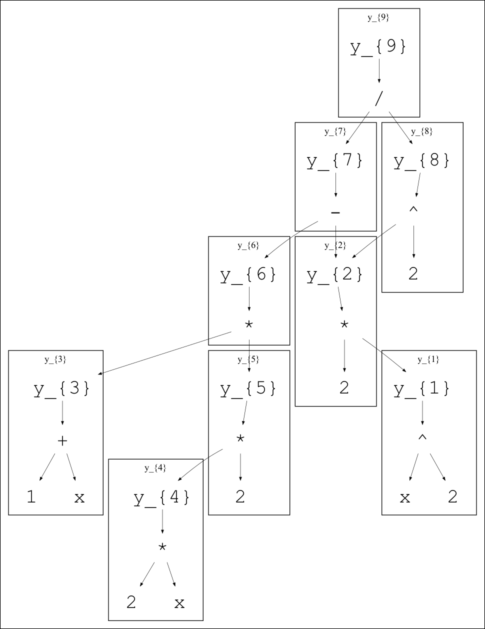

In [28]:
plot_graphviz(src)